In [1]:
import sys
import os

# Get the absolute path of the project's root directory
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add the project root to the Python path
if project_root not in sys.path:
    sys.path.append(project_root)

# Now you can import from your module
from src.utils.evaluation import calculate_metrics, plot_confusion_matrix



In [2]:
import os
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten
from src.utils.evaluation import calculate_metrics, plot_confusion_matrix # Import your evaluation functions

from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.models import Model

from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
import matplotlib.pyplot as plt

In [3]:
def plot_loss_curves(history, model_name):
    """
    Plots the training and validation loss curves from a Keras history object.
    """
    # Get the loss data from the history object
    training_loss = history.history['loss']
    validation_loss = history.history['val_loss']
    
    # Get the number of epochs
    epochs = range(1, len(training_loss) + 1)
    
    # Plot the curves
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, training_loss, 'bo-', label='Training Loss')
    plt.plot(epochs, validation_loss, 'ro-', label='Validation Loss')
    
    # Add titles and labels
    plt.title(f'Training and Validation Loss for {model_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (Binary Crossentropy)')
    plt.legend()
    plt.grid(True)
    plt.show()

In [4]:
# --- 1. Define Constants and Load Data Splits ---
PROCESSED_DATA_DIR = '../data/processed/'
train_df = pd.read_csv(os.path.join(PROCESSED_DATA_DIR, 'train.csv'))
val_df = pd.read_csv(os.path.join(PROCESSED_DATA_DIR, 'val.csv'))

In [5]:
# --- 2. Create a Function to Load and Flatten Images ---
def load_data_and_flatten(dataframe):
    """
    Loads .npy image files listed in a dataframe and flattens them into 1D vectors.
    """
    # Get the project root directory to build absolute paths
    project_root = os.path.abspath(os.path.join(PROCESSED_DATA_DIR, '..', '..'))
    
    images = []
    labels = []
    
    for idx, row in tqdm(dataframe.iterrows(), total=len(dataframe), desc="Loading data"):
        # Construct absolute path to the image
        img_path = os.path.join(project_root, row['filepath'])
        
        # Load the processed .npy image array
        img_array = np.load(img_path)
        
        # Flatten the 2D image (128x128) into a 1D vector (16384)
        images.append(img_array.flatten())
        labels.append(row['label'])
        
    return np.array(images), np.array(labels)

In [6]:
# --- 3. Prepare Training and Validation Sets ---
print("Preparing training data...")
X_train, y_train = load_data_and_flatten(train_df)

print("\nPreparing validation data...")
X_val, y_val = load_data_and_flatten(val_df)

print(f"\nTraining data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Preparing training data...


Loading data: 100%|██████████| 1750/1750 [00:01<00:00, 1014.41it/s]



Preparing validation data...


Loading data: 100%|██████████| 375/375 [00:00<00:00, 875.68it/s]


Training data shape: (1750, 16384)
Validation data shape: (375, 16384)


In [7]:
# --- 4. Train the Logistic Regression Model ---
print("\nTraining Logistic Regression model...")

# Initialize the model
# max_iter is increased to ensure the model converges with this many features
model = LogisticRegression(max_iter=1000, random_state=42)

# Train the model
model.fit(X_train, y_train)

print("Model training complete.")


Training Logistic Regression model...
Model training complete.


In [8]:
# --- 5. Evaluate the Model ---
print("\nEvaluating model on the validation set...")

# Make predictions on the validation data
y_pred = model.predict(X_val)

# Calculate and print accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f"\nValidation Accuracy: {accuracy:.4f}")

# Print a detailed classification report
print("\nClassification Report:")
print(classification_report(y_val, y_pred, target_names=['Normal (0)', 'Hemorrhage (1)']))


Evaluating model on the validation set...

Validation Accuracy: 0.9387

Classification Report:
                precision    recall  f1-score   support

    Normal (0)       0.96      0.97      0.96       328
Hemorrhage (1)       0.76      0.74      0.75        47

      accuracy                           0.94       375
     macro avg       0.86      0.86      0.86       375
  weighted avg       0.94      0.94      0.94       375



In [9]:
# --- 6. Build the MLP Model ---
print("\nBuilding the MLP model...")

# Get the number of features from the training data shape
input_features = X_train.shape[1]

model_mlp = Sequential([
    # Input layer - specify the input shape
    Dense(128, activation='relu', input_shape=(input_features,)),
    
    # A dropout layer to prevent overfitting
    Dropout(0.3),
    
    # Hidden layer
    Dense(64, activation='relu'),

    # Output layer for binary classification
    Dense(1, activation='sigmoid') 
])

# Compile the model
model_mlp.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Print the model summary
model_mlp.summary()


Building the MLP model...


C:\Users\khadk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,105,601 (8.03 MB)

 Trainable params: 2,105,601 (8.03 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# --- 7. Train the MLP Model ---
print("\nTraining the MLP model...")

history = model_mlp.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=10,  # You can experiment with more epochs
    batch_size=32,
    verbose=1
)

print("\nMLP model training complete.")


Training the MLP model...


Epoch 1/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8385 - loss: 0.7750 - val_accuracy: 0.8773 - val_loss: 0.2993
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8809 - loss: 0.2902 - val_accuracy: 0.8747 - val_loss: 0.2913
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8917 - loss: 0.2874 - val_accuracy: 0.9067 - val_loss: 0.2310
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8960 - loss: 0.2328 - val_accuracy: 0.8827 - val_loss: 0.2729
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9120 - loss: 0.2129 - val_accuracy: 0.9147 - val_loss: 0.2128
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9414 - loss: 0.1598 - val_accuracy: 0.8987 - val_loss: 0.2403
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9154 - loss: 0.1982 - val_accuracy: 0.8960 - val_loss: 0.2078
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9155 - loss: 0.1842 - val_accuracy: 0.9147 - v

In [11]:
# --- 8. Evaluate the MLP Model ---
print("\nEvaluating MLP model on the validation set...")

# Make predictions (the output will be probabilities)
y_pred_proba = model_mlp.predict(X_val)

# Convert probabilities to binary class labels (0 or 1)
y_pred_mlp = (y_pred_proba > 0.5).astype(int)

# Calculate and print accuracy
accuracy_mlp = accuracy_score(y_val, y_pred_mlp)
print(f"\nValidation Accuracy (MLP): {accuracy_mlp:.4f}")

# Print a detailed classification report
print("\nClassification Report (MLP):")
print(classification_report(y_val, y_pred_mlp, target_names=['Normal (0)', 'Hemorrhage (1)']))


Evaluating MLP model on the validation set...


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

Validation Accuracy (MLP): 0.8880

Classification Report (MLP):
                precision    recall  f1-score   support

    Normal (0)       0.89      0.99      0.94       328
Hemorrhage (1)       0.78      0.15      0.25        47

      accuracy                           0.89       375
     macro avg       0.83      0.57      0.59       375
  weighted avg       0.88      0.89      0.85       375



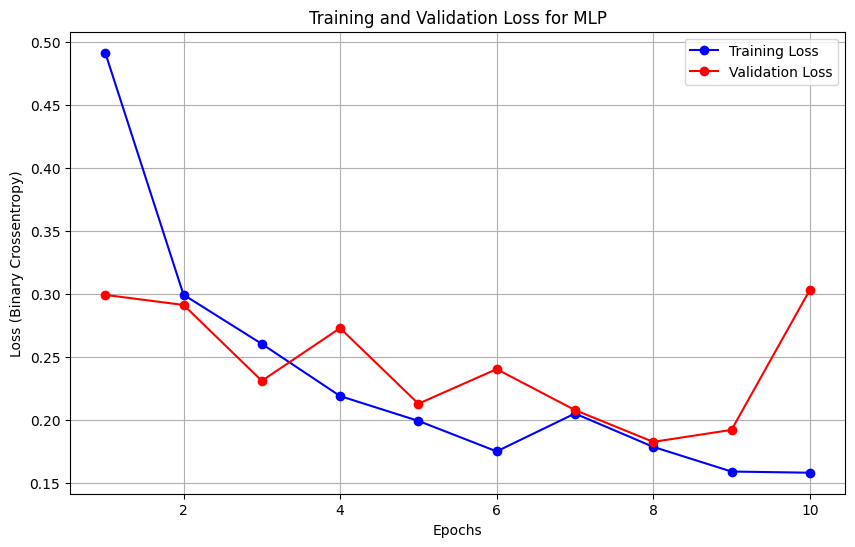

In [27]:
# history is the variable returned by model_mlp.fit()
plot_loss_curves(history, "MLP")

In [12]:
# --- 9. Prepare Data for CNN (Keep 2D Shape) ---

def load_data_2d(dataframe):
    """
    Loads .npy image files and keeps them in their 2D shape (width, height, channels).
    """
    # Get the project root directory to build absolute paths
    project_root = os.path.abspath(os.path.join(PROCESSED_DATA_DIR, '..', '..'))
    
    images = []
    labels = []
    
    for idx, row in tqdm(dataframe.iterrows(), total=len(dataframe), desc="Loading 2D data"):
        img_path = os.path.join(project_root, row['filepath'])
        img_array = np.load(img_path) # Shape is already (128, 128, 1)
        
        images.append(img_array)
        labels.append(row['label'])
        
    return np.array(images), np.array(labels)

print("\nPreparing 2D data for CNN...")
X_train_cnn, y_train_cnn = load_data_2d(train_df)
X_val_cnn, y_val_cnn = load_data_2d(val_df)

print(f"\nTraining data shape for CNN: {X_train_cnn.shape}")
print(f"Validation data shape for CNN: {X_val_cnn.shape}")


Preparing 2D data for CNN...


Loading 2D data: 100%|██████████| 375/375 [00:00<00:00, 2927.99it/s]


Training data shape for CNN: (1750, 128, 128, 1)
Validation data shape for CNN: (375, 128, 128, 1)


In [13]:
# --- 10. Build the CNN Model ---
print("\nBuilding the CNN model...")

model_cnn = Sequential([
    # Define the input shape
    Input(shape=(128, 128, 1)),
    
    # First convolutional block
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    # Second convolutional block
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    # Flatten the feature maps
    Flatten(),
    
    # Dense layer for classification
    Dense(128, activation='relu'),
    Dropout(0.5),
    
    # Output layer
    Dense(1, activation='sigmoid')
])

# Compile the model
model_cnn.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model_cnn.summary()


Building the CNN model...


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,391,873 (28.20 MB)

 Trainable params: 7,391,873 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# --- 11. Train the CNN Model ---
print("\nTraining the CNN model...")

history_cnn = model_cnn.fit(
    X_train_cnn,
    y_train_cnn,
    validation_data=(X_val_cnn, y_val_cnn),
    epochs=10,
    batch_size=32,
    verbose=1
)

print("\nCNN model training complete.")


Training the CNN model...
Epoch 1/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 17s 286ms/step - accuracy: 0.8472 - loss: 0.4634 - val_accuracy: 0.8987 - val_loss: 0.2630
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 21s 285ms/step - accuracy: 0.8929 - loss: 0.2454 - val_accuracy: 0.9067 - val_loss: 0.2483
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 16s 291ms/step - accuracy: 0.9180 - loss: 0.1958 - val_accuracy: 0.9253 - val_loss: 0.1977
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 16s 285ms/step - accuracy: 0.9396 - loss: 0.1373 - val_accuracy: 0.9307 - val_loss: 0.1773
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 21s 284ms/step - accuracy: 0.9643 - loss: 0.1038 - val_accuracy: 0.9360 - val_loss: 0.1653
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 16s 285ms/step - accuracy: 0.9737 - loss: 0.0803 - val_accuracy: 0.9493 - val_loss: 0.1657
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 16s 286ms/step - accuracy: 0.9756 - loss: 0.0590 - val_accuracy: 0.9413 - val_loss: 0.1559
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 21s 293ms/step - accuracy: 0.976


Evaluating CNN model on the validation set...
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step

Classification Report (CNN):
                precision    recall  f1-score   support

    Normal (0)       0.97      0.97      0.97       328
Hemorrhage (1)       0.77      0.79      0.78        47

      accuracy                           0.94       375
     macro avg       0.87      0.88      0.87       375
  weighted avg       0.94      0.94      0.94       375


Confusion Matrix (CNN):


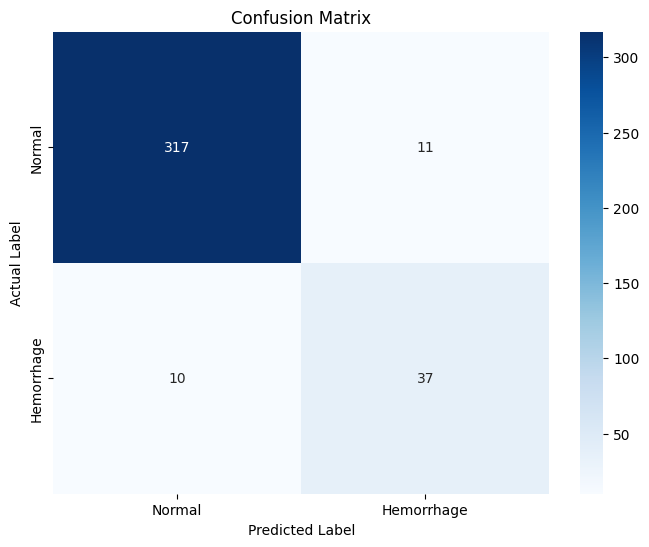

In [15]:
# --- 12. Evaluate the CNN Model ---
print("\nEvaluating CNN model on the validation set...")

# Make predictions
y_pred_proba_cnn = model_cnn.predict(X_val_cnn)
y_pred_cnn = (y_pred_proba_cnn > 0.5).astype(int)

# Print the classification report
print("\nClassification Report (CNN):")
print(classification_report(y_val_cnn, y_pred_cnn, target_names=['Normal (0)', 'Hemorrhage (1)']))

# Plot the confusion matrix using your new module
print("\nConfusion Matrix (CNN):")
plot_confusion_matrix(y_val_cnn, y_pred_cnn, class_names=['Normal', 'Hemorrhage'])

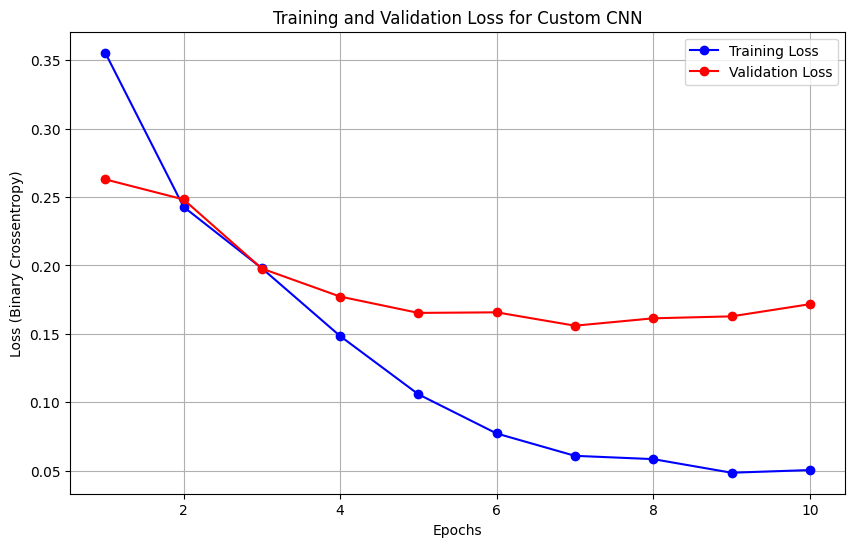

In [28]:
# history_cnn is the variable returned by model_cnn.fit()
plot_loss_curves(history_cnn, "Custom CNN")

In [16]:
# --- 13. Prepare Data for Transfer Learning (3-Channel) ---

def load_data_3channel(dataframe):
    """
    Loads .npy image files and converts them to a 3-channel format.
    """
    project_root = os.path.abspath(os.path.join(PROCESSED_DATA_DIR, '..', '..'))
    images = []
    labels = []
    
    for idx, row in tqdm(dataframe.iterrows(), total=len(dataframe), desc="Loading 3-channel data"):
        img_path = os.path.join(project_root, row['filepath'])
        img_array = np.load(img_path) # Shape is (128, 128, 1)
        
        # Stack the single channel 3 times to create an RGB-like image
        img_3channel = np.concatenate([img_array, img_array, img_array], axis=-1)
        
        images.append(img_3channel)
        labels.append(row['label'])
        
    return np.array(images), np.array(labels)

print("\nPreparing 3-channel data for Transfer Learning...")
X_train_tl, y_train_tl = load_data_3channel(train_df)
X_val_tl, y_val_tl = load_data_3channel(val_df)

print(f"\nTraining data shape for TL: {X_train_tl.shape}")
print(f"Validation data shape for TL: {X_val_tl.shape}")


Preparing 3-channel data for Transfer Learning...


Loading 3-channel data: 100%|██████████| 375/375 [00:00<00:00, 759.30it/s]



Training data shape for TL: (1750, 128, 128, 3)
Validation data shape for TL: (375, 128, 128, 3)


In [17]:
# --- 14. Build the Transfer Learning Model ---
print("\nBuilding the Transfer Learning model with VGG16 base...")

# Load the pre-trained VGG16 model without its top classification layer
base_model = VGG16(
    weights='imagenet',
    include_top=False, 
    input_shape=(128, 128, 3)
)

# Freeze the layers of the base model so they are not trained
base_model.trainable = False

# Create a new model on top
inputs = Input(shape=(128, 128, 3))
x = base_model(inputs, training=False) # Run the base model in inference mode
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)

model_tl = Model(inputs, outputs)

# Compile the model
model_tl.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model_tl.summary()


Building the Transfer Learning model with VGG16 base...


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,812,353 (64.13 MB)

 Trainable params: 2,097,665 (8.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [18]:
# --- 15. Train the Transfer Learning Model ---
print("\nTraining the Transfer Learning model...")

history_tl = model_tl.fit(
    X_train_tl,
    y_train_tl,
    validation_data=(X_val_tl, y_val_tl),
    epochs=10,
    batch_size=32,
    verbose=1
)

print("\nTransfer Learning model training complete.")


Training the Transfer Learning model...
Epoch 1/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 41s 623ms/step - accuracy: 0.8152 - loss: 0.8701 - val_accuracy: 0.8773 - val_loss: 0.2883
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 24s 433ms/step - accuracy: 0.8809 - loss: 0.2867 - val_accuracy: 0.8720 - val_loss: 0.2668
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 25s 458ms/step - accuracy: 0.8944 - loss: 0.2581 - val_accuracy: 0.8747 - val_loss: 0.2639
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 26s 472ms/step - accuracy: 0.8874 - loss: 0.2368 - val_accuracy: 0.8800 - val_loss: 0.2491
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - accuracy: 0.8870 - loss: 0.2375 - val_accuracy: 0.8827 - val_loss: 0.2453
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 25s 461ms/step - accuracy: 0.8978 - loss: 0.2144 - val_accuracy: 0.8907 - val_loss: 0.2564
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 25s 448ms/step - accuracy: 0.9014 - loss: 0.2107 - val_accuracy: 0.9040 - val_loss: 0.2241
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 24s 443ms/step - a


Evaluating Transfer Learning model on the validation set...
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 356ms/step

Classification Report (Transfer Learning):
                precision    recall  f1-score   support

    Normal (0)       0.97      0.89      0.93       328
Hemorrhage (1)       0.52      0.81      0.63        47

      accuracy                           0.88       375
     macro avg       0.75      0.85      0.78       375
  weighted avg       0.91      0.88      0.89       375


Confusion Matrix (Transfer Learning):


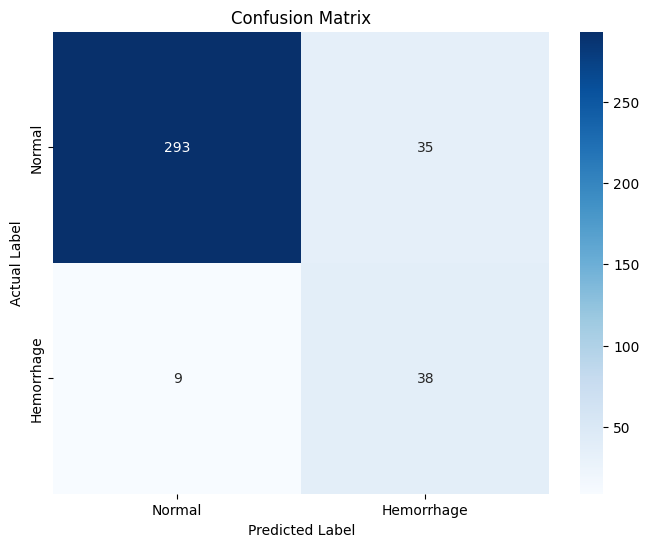

In [19]:
# --- 16. Evaluate the Transfer Learning Model ---
print("\nEvaluating Transfer Learning model on the validation set...")

# Make predictions
y_pred_proba_tl = model_tl.predict(X_val_tl)
y_pred_tl = (y_pred_proba_tl > 0.5).astype(int)

# Print the classification report
print("\nClassification Report (Transfer Learning):")
print(classification_report(y_val_tl, y_pred_tl, target_names=['Normal (0)', 'Hemorrhage (1)']))

# Plot the confusion matrix
print("\nConfusion Matrix (Transfer Learning):")
plot_confusion_matrix(y_val_tl, y_pred_tl, class_names=['Normal', 'Hemorrhage'])

In [20]:
#.....17  Unfreeze the base model to allow fine-tuning
base_model.trainable = True

# Keep the early layers frozen. Fine-tune from the last convolutional block.
# For VGG16, a good starting point is to fine-tune from block5.
for layer in base_model.layers[:-4]:
    layer.trainable = False

In [21]:
#.....18 Re-compile the model with a very low learning rate
model_tl.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), # Low learning rate
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [22]:
# --- 19. Fine-tune the Transfer Learning Model ---
print("\nFine-tuning the model...")
history_fine_tune = model_tl.fit(
    X_train_tl,
    y_train_tl,
    validation_data=(X_val_tl, y_val_tl),
    epochs=10 # Train for another 10 epochs
)


Fine-tuning the model...
Epoch 1/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 29s 509ms/step - accuracy: 0.9288 - loss: 0.1563 - val_accuracy: 0.8907 - val_loss: 0.2082
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 27s 496ms/step - accuracy: 0.9435 - loss: 0.1291 - val_accuracy: 0.9120 - val_loss: 0.1915
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 27s 497ms/step - accuracy: 0.9623 - loss: 0.1006 - val_accuracy: 0.9227 - val_loss: 0.1877
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 27s 496ms/step - accuracy: 0.9676 - loss: 0.0870 - val_accuracy: 0.9173 - val_loss: 0.2624
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 27s 496ms/step - accuracy: 0.9714 - loss: 0.0858 - val_accuracy: 0.9200 - val_loss: 0.1801
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 27s 497ms/step - accuracy: 0.9801 - loss: 0.0666 - val_accuracy: 0.9360 - val_loss: 0.1687
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 27s 496ms/step - accuracy: 0.9818 - loss: 0.0623 - val_accuracy: 0.9467 - val_loss: 0.1639
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 28s 503ms/step - accuracy: 0.9820


Evaluating Transfer Learning model on the validation set...
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 365ms/step

Classification Report (Transfer Learning):
                precision    recall  f1-score   support

    Normal (0)       0.96      0.96      0.96       328
Hemorrhage (1)       0.74      0.74      0.74        47

      accuracy                           0.94       375
     macro avg       0.85      0.85      0.85       375
  weighted avg       0.94      0.94      0.94       375


Confusion Matrix (Transfer Learning):


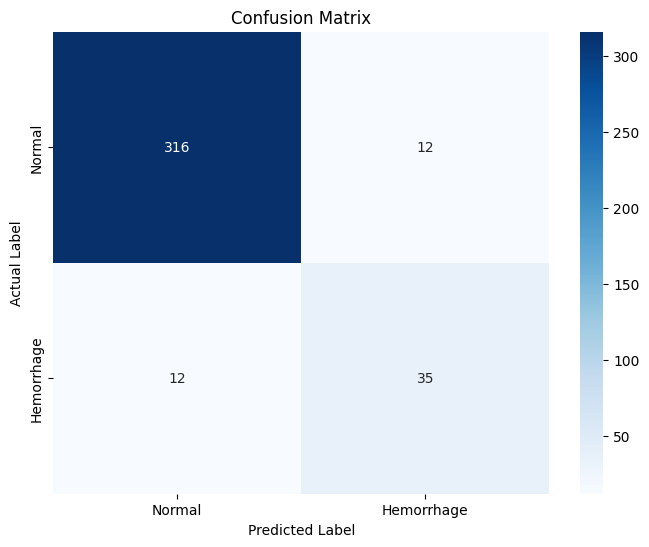

In [23]:
# --- 20. Evaluate the Transfer Learning Model ---
print("\nEvaluating Transfer Learning model on the validation set...")

# Make predictions
y_pred_proba_tl = model_tl.predict(X_val_tl)
y_pred_tl = (y_pred_proba_tl > 0.5).astype(int)

# Print the classification report
print("\nClassification Report (Transfer Learning):")
print(classification_report(y_val_tl, y_pred_tl, target_names=['Normal (0)', 'Hemorrhage (1)']))

# Plot the confusion matrix
print("\nConfusion Matrix (Transfer Learning):")
plot_confusion_matrix(y_val_tl, y_pred_tl, class_names=['Normal', 'Hemorrhage'])

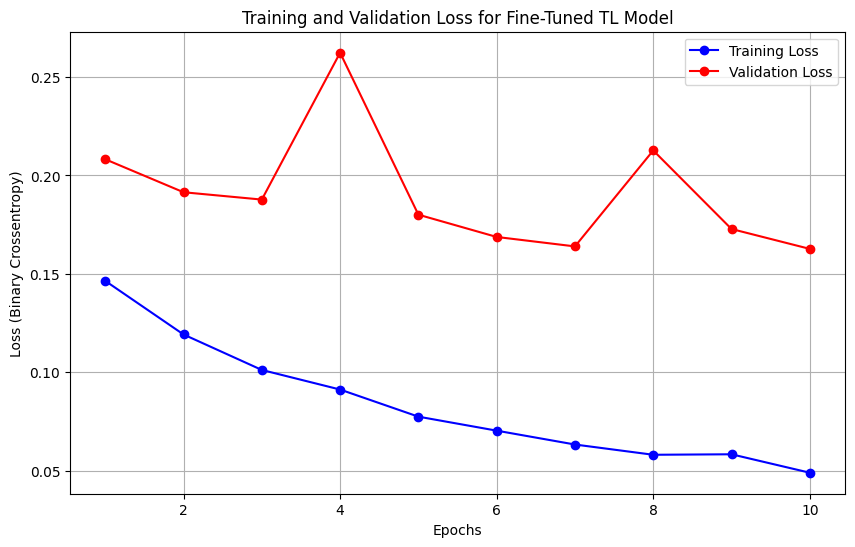

In [29]:
# history_fine_tune is the variable returned by model_tl.fit()
plot_loss_curves(history_fine_tune, "Fine-Tuned TL Model")

In [24]:
 #.....21. Create a data augmentation pipeline
data_augmentation = Sequential([
    Input(shape=(128, 128, 1)),
    RandomFlip("horizontal"),
    RandomRotation(0.1), # a 10% rotation range
    RandomZoom(0.1),     # a 10% zoom range
], name="data_augmentation")

In [25]:
# --- Build the Augmented CNN Model ---
print("\nBuilding the Augmented CNN model...")

model_cnn_augmented = Sequential([
    # Add the data augmentation pipeline as the first layer
    data_augmentation,
    
    # The rest of your CNN architecture is the same
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the augmented model
model_cnn_augmented.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model_cnn_augmented.summary()

# --- Train the Augmented CNN Model ---
print("\nTraining the Augmented CNN model...")

history_cnn_augmented = model_cnn_augmented.fit(
    X_train_cnn,
    y_train_cnn,
    validation_data=(X_val_cnn, y_val_cnn),
    epochs=15, # Train for a few more epochs as augmentation makes the task harder
    batch_size=32,
    verbose=1
)

# --- Evaluate the Augmented CNN Model ---
print("\nEvaluating Augmented CNN model...")
y_pred_proba_aug = model_cnn_augmented.predict(X_val_cnn)
y_pred_aug = (y_pred_proba_aug > 0.5).astype(int)

print("\nClassification Report (Augmented CNN):")
print(classification_report(y_val_cnn, y_pred_aug, target_names=['Normal (0)', 'Hemorrhage (1)']))


Building the Augmented CNN model...


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,391,873 (28.20 MB)

 Trainable params: 7,391,873 (28.20 MB)

 Non-trainable params: 0 (0.00 B)


Training the Augmented CNN model...
Epoch 1/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - accuracy: 0.8314 - loss: 0.4953 - val_accuracy: 0.8747 - val_loss: 0.3154
Epoch 2/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.8824 - loss: 0.3204 - val_accuracy: 0.8827 - val_loss: 0.3223
Epoch 3/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.8648 - loss: 0.3310 - val_accuracy: 0.8747 - val_loss: 0.3414
Epoch 4/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.8802 - loss: 0.3174 - val_accuracy: 0.8747 - val_loss: 0.3017
Epoch 5/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.8674 - loss: 0.3017 - val_accuracy: 0.8800 - val_loss: 0.2956
Epoch 6/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.8760 - loss: 0.3179 - val_accuracy: 0.8800 - val_loss: 0.2828
Epoch 7/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.8721 - loss: 0.3080 - val_accuracy: 0.8800 - val_loss: 0.2773
Epoch 8/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.8797 - lo

Weight for Normal (0): 0.57
Weight for Hemorrhage (1): 3.92

Re-training the Augmented CNN model with class weights...
Epoch 1/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.8199 - loss: 0.6181 - val_accuracy: 0.7387 - val_loss: 0.4320
Epoch 2/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.7524 - loss: 0.4874 - val_accuracy: 0.7680 - val_loss: 0.4322
Epoch 3/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.7636 - loss: 0.4867 - val_accuracy: 0.7067 - val_loss: 0.5014
Epoch 4/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.7154 - loss: 0.5130 - val_accuracy: 0.7680 - val_loss: 0.4076
Epoch 5/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.7815 - loss: 0.4791 - val_accuracy: 0.7920 - val_loss: 0.3636
Epoch 6/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.7738 - loss: 0.4349 - val_accuracy: 0.7813 - val_loss: 0.4224
Epoch 7/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.7585 - loss: 0.4476 - val_accuracy: 0.7733 - val_loss:

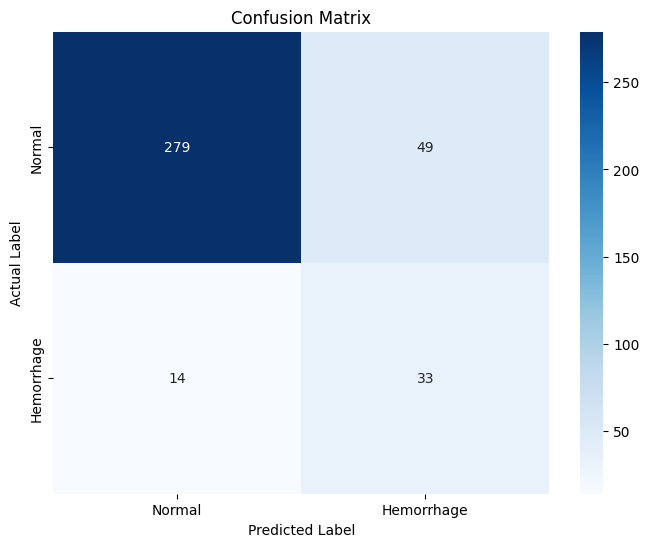

In [26]:
# --- Calculate Class Weights to handle imbalance ---
# This gives more importance to the minority class (Hemorrhage)
neg_count = np.sum(y_train_cnn == 0)
pos_count = np.sum(y_train_cnn == 1)
total_count = len(y_train_cnn)

weight_for_0 = (1 / neg_count) * (total_count / 2.0)
weight_for_1 = (1 / pos_count) * (total_count / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print(f"Weight for Normal (0): {class_weight[0]:.2f}")
print(f"Weight for Hemorrhage (1): {class_weight[1]:.2f}")


# --- Re-train the Augmented CNN Model with Class Weights ---
print("\nRe-training the Augmented CNN model with class weights...")

# We use the same compiled model (model_cnn_augmented)
history_cnn_weighted = model_cnn_augmented.fit(
    X_train_cnn,
    y_train_cnn,
    validation_data=(X_val_cnn, y_val_cnn),
    epochs=15,
    batch_size=32,
    class_weight=class_weight, # Apply the calculated weights here
    verbose=1
)


# --- Re-evaluate the Augmented CNN Model ---
print("\nEvaluating weighted & augmented CNN model...")
y_pred_proba_weighted = model_cnn_augmented.predict(X_val_cnn)
y_pred_weighted = (y_pred_proba_weighted > 0.5).astype(int)

print("\nClassification Report (Weighted & Augmented CNN):")
print(classification_report(y_val_cnn, y_pred_weighted, target_names=['Normal (0)', 'Hemorrhage (1)']))

print("\nConfusion Matrix (Weighted & Augmented CNN):")
plot_confusion_matrix(y_val_cnn, y_pred_weighted, class_names=['Normal', 'Hemorrhage'])


--- Ensembling Models ---
Getting predictions from Custom CNN...
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Getting predictions from Fine-Tuned TL Model...
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 298ms/step
Averaging predictions...

--- Evaluating Ensemble Model ---
Validation Accuracy (Ensemble): 0.9547

Classification Report (Ensemble):
                precision    recall  f1-score   support

    Normal (0)       0.97      0.98      0.97       328
Hemorrhage (1)       0.83      0.81      0.82        47

      accuracy                           0.95       375
     macro avg       0.90      0.89      0.90       375
  weighted avg       0.95      0.95      0.95       375


Confusion Matrix (Ensemble):


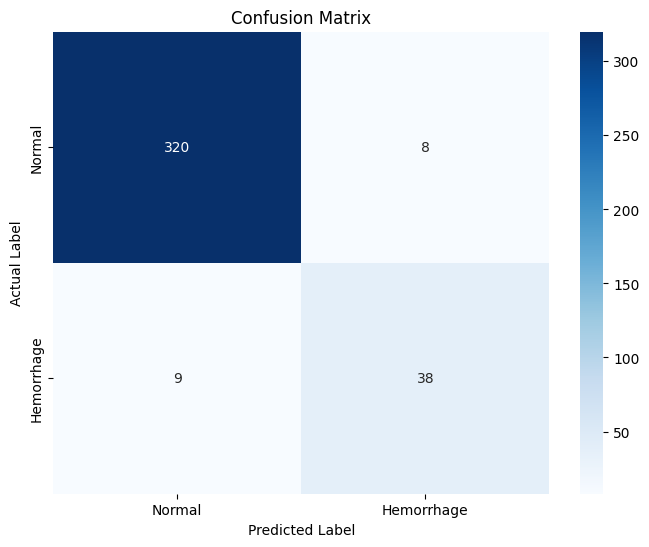

In [30]:
# This code assumes you have already trained 'model_cnn' and 'model_tl' (the fine-tuned one)
# and have the validation data 'X_val_cnn', 'X_val_tl', and 'y_val_cnn' ready.

print("\n--- Ensembling Models ---")

# 1. Get predictions (probabilities) from both models
print("Getting predictions from Custom CNN...")
y_pred_proba_cnn = model_cnn.predict(X_val_cnn)

print("Getting predictions from Fine-Tuned TL Model...")
y_pred_proba_tl = model_tl.predict(X_val_tl)

# 2. Average the probabilities from both models
print("Averaging predictions...")
y_pred_proba_ensemble = (y_pred_proba_cnn + y_pred_proba_tl) / 2.0

# 3. Convert averaged probabilities to final class labels
y_pred_ensemble = (y_pred_proba_ensemble > 0.5).astype(int)

# 4. Evaluate the ensemble's performance
print("\n--- Evaluating Ensemble Model ---")
accuracy_ensemble = accuracy_score(y_val_cnn, y_pred_ensemble)
print(f"Validation Accuracy (Ensemble): {accuracy_ensemble:.4f}")

print("\nClassification Report (Ensemble):")
print(classification_report(y_val_cnn, y_pred_ensemble, target_names=['Normal (0)', 'Hemorrhage (1)']))

print("\nConfusion Matrix (Ensemble):")
plot_confusion_matrix(y_val_cnn, y_pred_ensemble, class_names=['Normal', 'Hemorrhage'])